In [293]:
#Import required packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [294]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

540
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


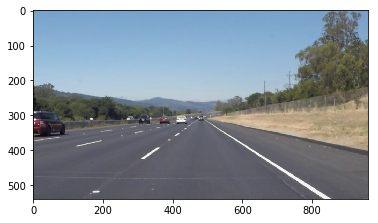

In [295]:
#Read image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
image_shape = image.shape
print(image_shape[0])

#Print stats and plot
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

In [296]:
def convertToHSL(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

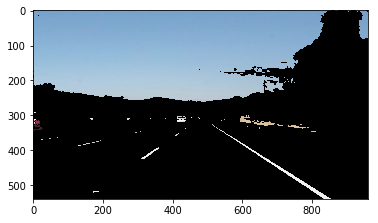

In [297]:
def filterWhiteYellow(image):
    #Make a copy of the original image
    image_initial = np.copy(image)
    
    imageHSL = convertToHSL(image_initial)
    # white color mask
    white_lower = np.uint8([  0, 190,   0])
    white_upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(imageHSL, white_lower, white_upper)
    
    # yellow color mask
    yellow_lower = np.uint8([ 0,   0, 100])
    yellow_upper = np.uint8([ 150, 255, 255])
    yellow_mask = cv2.inRange(imageHSL, yellow_lower, yellow_upper)
    
    # combine the mask
    mask_combined = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask_combined)
    return masked_image

filterImage = filterWhiteYellow(image)
plt.imshow(filterImage)

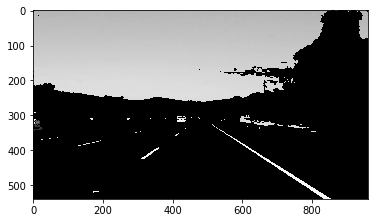

In [298]:
def grayscale(image):       
    #Convert image to grayscale
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    
grayImage = grayscale(filterImage)
plt.imshow(grayImage, cmap='Greys_r')   

In [299]:
def gaussianBlur(image, kernel_size):
    #Apply a Gaussian Noise kernel
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

def canny(image, low_threshold, high_threshold):
    #Apply Canny transform
    return cv2.Canny(image, low_threshold, high_threshold)

In [300]:
def regionOfInterest(image, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(image)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(image.shape) > 2:
        channel_count = image.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [301]:
def drawLines(image, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)   

In [302]:
def houghLines(image, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(image, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    drawLines(line_image, lines)
    return line_image

In [303]:
def weightedImage(image, initial_image, α=0.5, β=1., γ=0.):
    #bin_image = np.dstack((initial_image,initial_image, initial_image))
    return cv2.addWeighted(initial_image, α, image, β, γ)

In [304]:
def process_image(image):
    
    imshape = image.shape
    
    filterImg = filterWhiteYellow(image)
    gray = grayscale(filterImg)    
    
    kernel_size = 7
    blur = gaussianBlur(gray, kernel_size)
    
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur, low_threshold, high_threshold)
    
    # the vertices are an array of polygons (i.e array of arrays) and the data type must be integer
    vertices = np.array([[(0,imshape[0]),(imshape[1]*.45, imshape[0]*0.6), (imshape[1]*.5, imshape[0]*0.6), (imshape[1],imshape[0])]], dtype=np.int32)
    roi = regionOfInterest(edges,vertices=vertices)
    
    # Define the Hough transform parameters
    rho = 1
    theta = np.pi/180
    threshold = 50
    min_line_len = 50
    max_line_gap = 200 
    yLimit = int(imshape[0]*0.6) #Top endpoint of ROI on the Y axis
    hough = houghLines(roi, rho, theta, threshold, min_line_len, max_line_gap)
    result = weightedImage(hough, image, α=0.5, β=1., γ=0.)
    
    return result

Image solidWhiteCurve.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


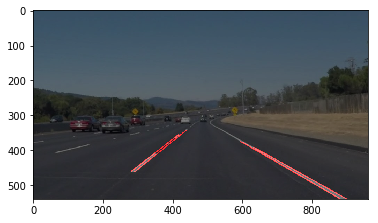

Image solidWhiteRight.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


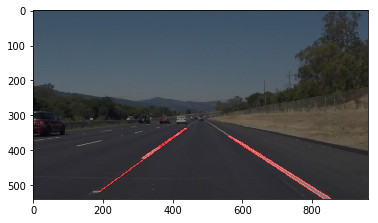

Image solidYellowCurve.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


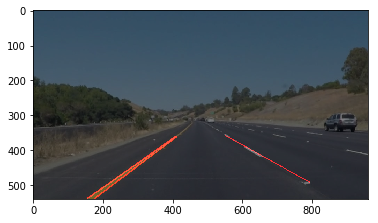

Image solidYellowCurve2.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


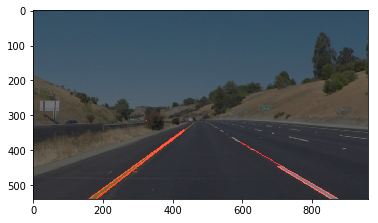

Image solidYellowLeft.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


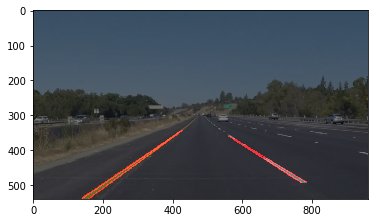

Image whiteCarLaneSwitch.jpg displayed below is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


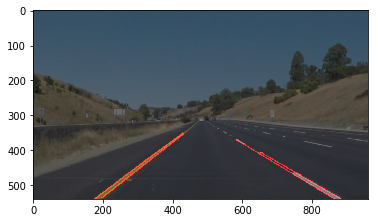

In [305]:
# Printing out test images with lane fill
for image_file in os.listdir("test_images/"):
    img = mpimg.imread("test_images/" + image_file)
    print('Image ' + image_file +' displayed below is:', type(img), 'with dimensions:', img.shape)
    processed_img = process_image(img)
    # mpimg.imsave('test_images_output/Processed_'+ image_file, processed_img) # Did this the first time
    plt.imshow(processed_img)
    plt.show()

In [306]:
white_output = 'test_videos_output/solidWhiteRight.mp4'

clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

OSError: [WinError 6] The handle is invalid